# P1: Import Libraries

In [1]:
import os
import os.path as osp
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from PIL import Image, ImageDraw



# P2: Creating a Custom Dataset for your files

In [2]:
class CustomTrafficSignDataset(Dataset):
    def __init__(self, annotations_dir, img_dir, transform=None, target_transfrom=None):
        self.annotations_dir = annotations_dir
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transfrom
        self.image_files = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]

    # get object info from xml_file
    def parse_voc_xml_annotation(self, xml_file):
        # read the xml_file
        tree = ET.parse(xml_file)
        root = tree.getroot()

        # find objects
        bboxes = []
        for obj in root.findall("object"):
            obj_name = obj.find("name").text
            bnd_box = obj.find("bndbox")
            bbox = [
                int(bnd_box.find("xmin").text),
                int(bnd_box.find("ymin").text),
                int(bnd_box.find("xmax").text),
                int(bnd_box.find("ymax").text),
            ]

            # take the size of orginal image from annotation files
            size = root.find("size")
            width = int(size.find("width").text)
            height = int(size.find("height").text)

            # Normalize bounding box coordinates
            xmin_norm = bbox[0] / width
            ymin_norm = bbox[1] / height
            xmax_norm = bbox[2] / width
            ymax_norm = bbox[3] / height
            normalize_bbox = [xmin_norm, ymin_norm, xmax_norm, ymax_norm]

            # save the name, coordinates of the bounding box to
            label = {
                "name": obj_name,
                "bndbox": normalize_bbox,
            }
            bboxes.append(label)
        return bboxes

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # operate with img files
        img_filename = self.image_files[idx]
        img_path = osp.join(self.img_dir, img_filename)
        img = Image.open(img_path).convert("RGB")

        # operate with xml files
        xml_files = img_filename.replace(".jpg", ".xml")
        xml_path = osp.join(self.annotations_dir, xml_files)

        # Check existence of xml files
        if os.path.exists(xml_path):
            labels = self.parse_voc_xml_annotation(xml_path)
        else:
            print(f"Warning: Annotation file {xml_path} not found.")

        # transform img and labels
        if self.transform:
            img = self.transform(img)

        if self.target_transform:
            labels = self.target_transform(labels)

        return img, labels


# P3: Set up collate_fn

In [3]:
def collate_fn(batch):
    images, targets = list(zip(*batch))
    return torch.stack(images, 0), targets  # images as tensor, targets as list


# P4: Get traffic sign transforms

In [4]:
def get_traffic_sign_transforms():
    transform = T.Compose(
        [
            T.Resize((224,224)),
            T.ToTensor(),
        ]
    )

    return transform


# P5: Preparing your data for training with DataLoaders

In [5]:
def create_dataloader(annotations_dir, img_dir, transform, batch_size=10, shuffle=True):
    dataset = CustomTrafficSignDataset(annotations_dir, img_dir, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    return dataloader


# P6: Draw the bounding box

In [6]:
def draw_boxes(image, labels):
    """
    Vẽ các bounding boxes và nhãn lên hình ảnh đã resize.
    Các tọa độ đã chuẩn hóa sẽ được nhân lại với kích thước ảnh để chuyển về pixel.
    """
    draw = ImageDraw.Draw(image)
    resized_width, resized_height = image.size  # Kích thước ảnh đã resize

    # In ra các label và bounding box để kiểm tra
    print(f"Drawing labels: {labels}")

    for label in labels:
        bndbox = label["bndbox"]
        xmin = int(bndbox[0] * resized_width)
        ymin = int(bndbox[1] * resized_height)
        xmax = int(bndbox[2] * resized_width)
        ymax = int(bndbox[3] * resized_height)

        # Vẽ bounding box và nhãn
        draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)
        draw.text((xmin, ymin), label["name"], fill="red")
    
    return image


# P7: Iterate through the DataLoader

In [7]:
def test_dataloader(dataloader, draw_funct, num_batches):
    for batch_idx, (images, labels) in enumerate(dataloader):
        if batch_idx >= num_batches:
            break 
        print("---------------------------")
        print(f"Batch {batch_idx + 1} is: ")
        print("---------------------------")

        for i in range(len(images)):
            # convert tensor to PIL Image type
            image_pil = T.ToPILImage()(images[i])

            # draw bounding boxes on img
            image_pil = draw_funct(image_pil, labels[i])

            # show bounding box
            plt.imshow(image_pil)
            plt.axis("off")
            plt.title(f"Batch: {batch_idx + 1}, Image: {i + 1}")
            plt.show()

            # check the labels
            print(f"Labels: {labels[i]}")


# Main

In [8]:
def main(num_batches):
    # Paths to annotation and image directories
    annotations_dir = "../Vietnam-Traffic-Sign-Detection.v6i.voc/train/"
    img_dir = "../Vietnam-Traffic-Sign-Detection.v6i.voc/train/"
    
    transform = get_traffic_sign_transforms()

    # Create DataLoader
    dataloader = create_dataloader(annotations_dir, img_dir, transform)

    # Iterate through 20 batches and draw bounding boxes
    test_dataloader(dataloader, draw_boxes, num_batches)  


# Run here

---------------------------
Batch 1 is: 
---------------------------
Drawing labels: [{'name': 'P.131a', 'bndbox': [0.284375, 0.3484375, 0.3046875, 0.3828125]}]


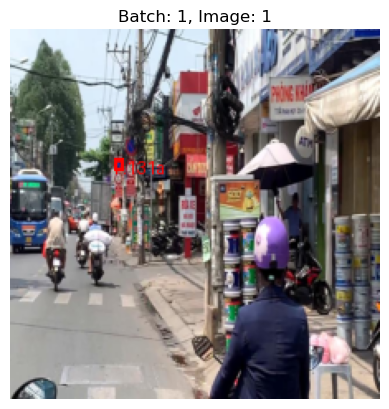

Labels: [{'name': 'P.131a', 'bndbox': [0.284375, 0.3484375, 0.3046875, 0.3828125]}]
Drawing labels: [{'name': 'R.302a', 'bndbox': [0.596875, 0.4078125, 0.6234375, 0.4625]}, {'name': 'P.102', 'bndbox': [0.5953125, 0.3546875, 0.6234375, 0.4109375]}, {'name': 'P.127', 'bndbox': [0.9359375, 0.278125, 0.984375, 0.353125]}, {'name': 'P.115', 'bndbox': [0.9375, 0.3546875, 0.9859375, 0.4296875]}]


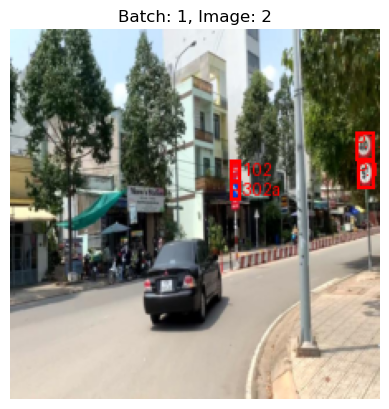

Labels: [{'name': 'R.302a', 'bndbox': [0.596875, 0.4078125, 0.6234375, 0.4625]}, {'name': 'P.102', 'bndbox': [0.5953125, 0.3546875, 0.6234375, 0.4109375]}, {'name': 'P.127', 'bndbox': [0.9359375, 0.278125, 0.984375, 0.353125]}, {'name': 'P.115', 'bndbox': [0.9375, 0.3546875, 0.9859375, 0.4296875]}]
Drawing labels: [{'name': 'W.210', 'bndbox': [0.3640625, 0.56875, 0.4234375, 0.6578125]}]


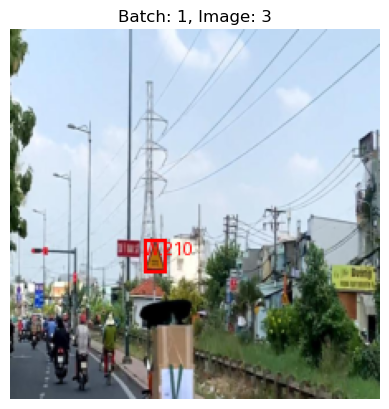

Labels: [{'name': 'W.210', 'bndbox': [0.3640625, 0.56875, 0.4234375, 0.6578125]}]
Drawing labels: [{'name': 'P.131a', 'bndbox': [0.6140625, 0.303125, 0.8171875, 0.6515625]}]


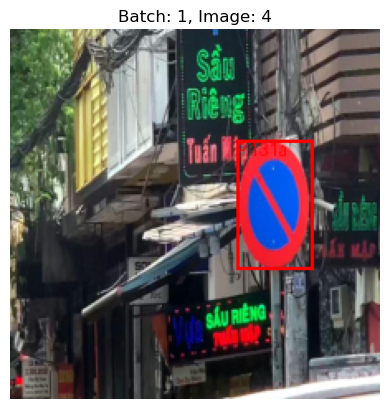

Labels: [{'name': 'P.131a', 'bndbox': [0.6140625, 0.303125, 0.8171875, 0.6515625]}]
Drawing labels: [{'name': 'P.104', 'bndbox': [0.3421875, 0.3734375, 0.40625, 0.503125]}, {'name': 'R.407a', 'bndbox': [0.7203125, 0.5859375, 0.76875, 0.7015625]}]


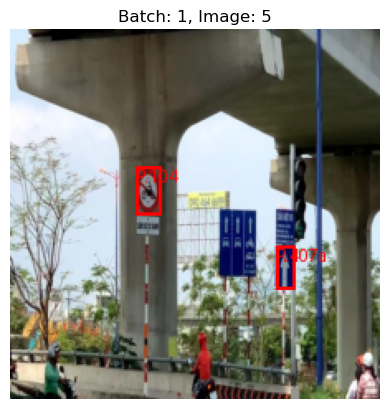

Labels: [{'name': 'P.104', 'bndbox': [0.3421875, 0.3734375, 0.40625, 0.503125]}, {'name': 'R.407a', 'bndbox': [0.7203125, 0.5859375, 0.76875, 0.7015625]}]
Drawing labels: []


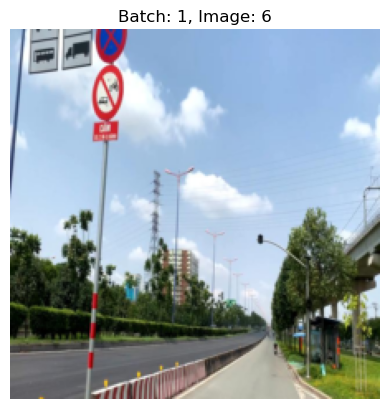

Labels: []
Drawing labels: [{'name': 'W.203b', 'bndbox': [0.078125, 0.6109375, 0.1921875, 0.7984375]}, {'name': 'W.227', 'bndbox': [0.38125, 0.671875, 0.496875, 0.85625]}, {'name': 'P.103a', 'bndbox': [0.2578125, 0.209375, 0.378125, 0.41875]}, {'name': 'R.301c', 'bndbox': [0.225, 0.625, 0.34375, 0.8265625]}]


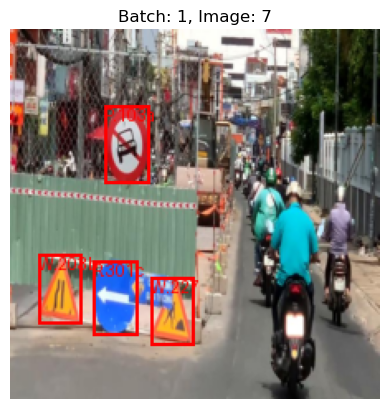

Labels: [{'name': 'W.203b', 'bndbox': [0.078125, 0.6109375, 0.1921875, 0.7984375]}, {'name': 'W.227', 'bndbox': [0.38125, 0.671875, 0.496875, 0.85625]}, {'name': 'P.103a', 'bndbox': [0.2578125, 0.209375, 0.378125, 0.41875]}, {'name': 'R.301c', 'bndbox': [0.225, 0.625, 0.34375, 0.8265625]}]
Drawing labels: [{'name': 'W.201a', 'bndbox': [0.34375, 0.5671875, 0.38125, 0.6265625]}]


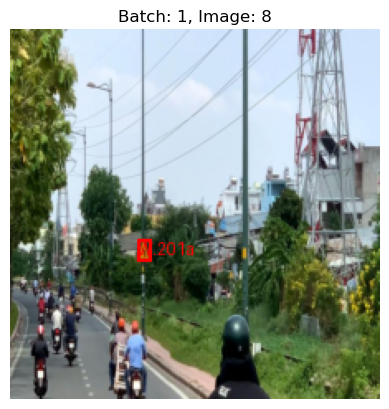

Labels: [{'name': 'W.201a', 'bndbox': [0.34375, 0.5671875, 0.38125, 0.6265625]}]
Drawing labels: [{'name': 'P.131a', 'bndbox': [0.2609375, 0.3921875, 0.503125, 0.83125]}]


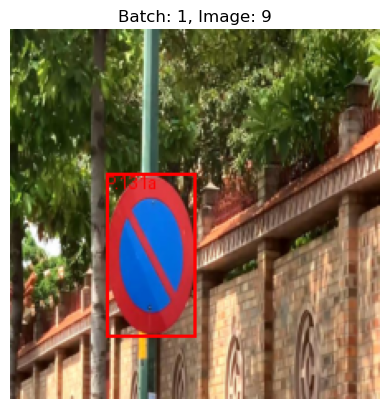

Labels: [{'name': 'P.131a', 'bndbox': [0.2609375, 0.3921875, 0.503125, 0.83125]}]
Drawing labels: [{'name': 'P.131a', 'bndbox': [0.3484375, 0.4328125, 0.4375, 0.590625]}, {'name': 'P.106a', 'bndbox': [0.2015625, 0.4015625, 0.2765625, 0.5375]}]


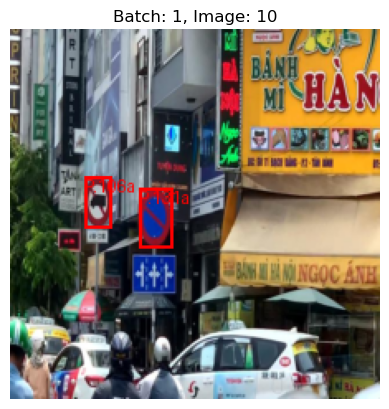

Labels: [{'name': 'P.131a', 'bndbox': [0.3484375, 0.4328125, 0.4375, 0.590625]}, {'name': 'P.106a', 'bndbox': [0.2015625, 0.4015625, 0.2765625, 0.5375]}]


In [9]:
if __name__ == '__main__':
    num_batches = int(input("Enter the number of batches: "))
    main(num_batches)
